# 🧹 Очистка и подготовка данных

## 🎯 Ключевые цели
Провести очистку и трансформацию данных на основе рекомендаций первичного анализа: устранение дубликатов, фильтрацию аномалий, корректировку форматов и объединение таблиц в целостный набор данных для последующего анализа.

---

## 📋 Этапы очистки данных

### 1. 📥 Подготовка рабочей среды
- Импорт необходимых библиотек анализа (`pandas`, `numpy`)
- Загрузка исходных файлов данных в соответствующие датафреймы

### 2. 🔄 Устранение дубликатов в `users_go.csv`
- **Дубликаты**: Поиск и удаление полностью идентичных записей (Устранение по неявности не требуется т.к на этапе первичного анализа подтвердилось, что они совпадают)

### 3. 🎯 Фильтрация аномальных значений
- **Колонка `distance`**: Удаление аномальных расстояний несоответствующих времени, за которое расстояние проходилось
- **Колонка `duration`**: Корректировка временных аномалий

### 4. 🔗 Консолидация данных
- **Объединение таблиц**: Соединение `rides_go`, `users_go` и `subscriptions_go` по ключевым идентификаторам
- **Структурирование**: Создание единой согласованной таблицы для анализа
- **Оптимизация форматов**: Приведение типов данных к оптимальным для работы

---

## 📊 Итоги этапа очистки
На основе первичного анализа будут очищены данные для дальнейшей работы в EDA, создание общей таблицу для удобства работы с данными.

## 1.1. Импортируем нужные библиотеки

In [9]:
import pandas as pd
import numpy as np

from utils import joinpath, print_duplicates, scatterplot

## 1.2. Загружаем данные для дальнейшей работы с ними

Создадим словари с настройками для правильной загрузки данных затем через `pandas` загружаем данные.

In [10]:
# Настройка `subscriptions_go.csv`
subscriptions_options = {
    "filepath_or_buffer": joinpath("data", "subscriptions_go.csv"),
    "encoding": "utf-8",
}

# Настройка для `users_go.csv`
users_options = {
    "filepath_or_buffer": joinpath("data", "users_go.csv"),
    "encoding": "utf-8",
}

# Настройка для `rides_go.csv`
rides_options = {
    "filepath_or_buffer": joinpath("data", "rides_go.csv"),
    "encoding": "utf-8",
    "parse_dates": ["date"],
}

subscriptions_df = pd.read_csv(**subscriptions_options)

users_df = pd.read_csv(**users_options)

rides_df = pd.read_csv(**rides_options)

## 2.1. Очистка дубликатов `users_go.csv`

In [11]:
cleaned_users_df = users_df.drop_duplicates(keep="first")

print_duplicates(
    cleaned_users_df, return_masked=False
)  # Проверяем удалились ли дубликаты

Количество дубликатов: 0.


## 2.2. Сохраняем очищенные данные в виде `cleaned_users_go.csv`

In [12]:
cleaned_users_df.to_csv(joinpath("data", "cleaned_users_go.csv"), index=False)

## 3.1. Очистка аномалий в признаках `distance` и `duration`

#### В этом блоке рассматриваем фильтрацию аномалий для `distance`, `duration` из файла `rides_go.csv`

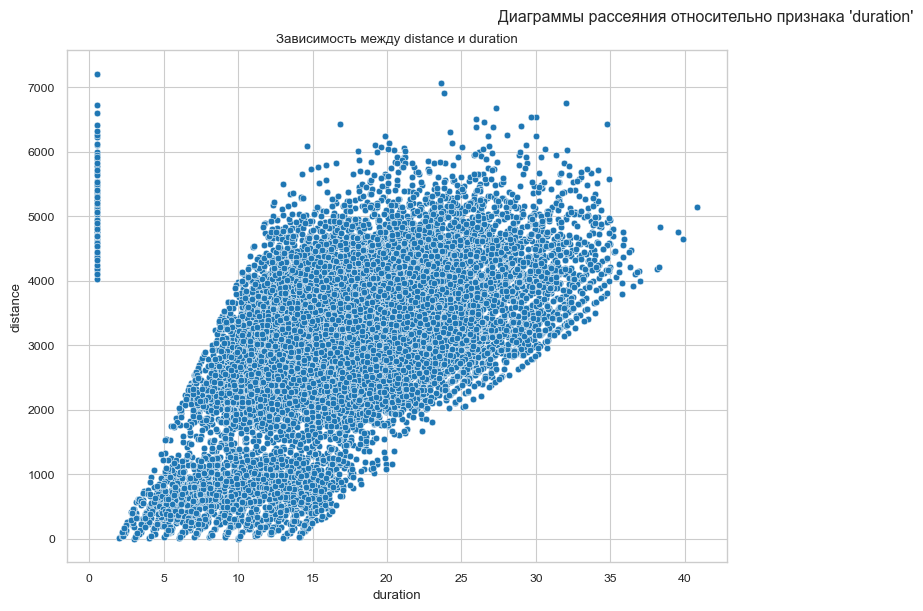

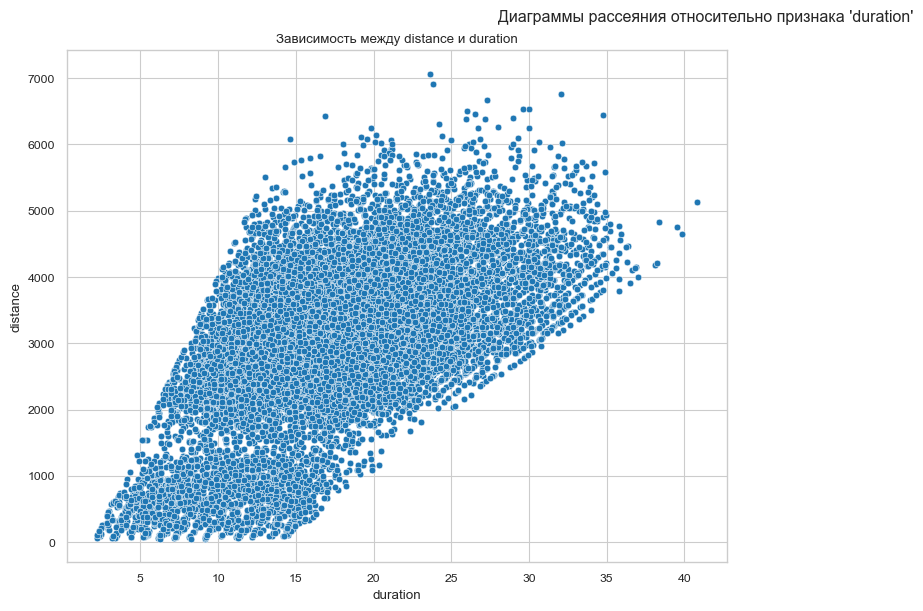

In [13]:
cleaned_rides_df = rides_df[
    (rides_df["duration"] > 1) & (rides_df["distance"] > 50)
]  # Формула фильтрации
scatterplot(rides_df, "duration", ["distance"])
scatterplot(cleaned_rides_df, "duration", ["distance"])

Как видим за счет фильтрации мы убрали сбои в системе, которые показывали 0.5 минут, а так же убрали аномалии, которые при достаточно временом промежутки имели слишком маленькие значения по дистанции (ниже 50м)

## 3.2. Приводим `distance` и `duration` в более удобный тип и сохраняем очищенные данные.

In [14]:
# Приводим в удобный тип данные, а так же округляем время поездки в большую сторону
cleaned_rides_df.loc[:, "distance"] = cleaned_rides_df["distance"].astype(int)
cleaned_rides_df.loc[:, "duration"] = (
    cleaned_rides_df["duration"].apply(np.ceil).astype(int)
)

# Сохраняем очищенные данные
cleaned_rides_df.to_csv(joinpath("data", "cleaned_rides_go.csv"), index=False)

## 4.1. Используем `merge` для создание общей таблицы данных.

In [15]:
cleaned_rides_users_subscriptions_df = cleaned_rides_df.merge(
    cleaned_users_df, on="user_id"
).merge(subscriptions_df, on="subscription_type")

cleaned_rides_users_subscriptions_df.sample(10)

,user_id,distance,duration,date,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
13389,1208,2948.0,15.0,2021-07-17,Леонид,28,Екатеринбург,free,8,50,0
8204,828,2390.0,12.0,2021-10-08,Вадим,30,Екатеринбург,free,8,50,0
8915,882,3213.0,15.0,2021-09-12,Ян,27,Сочи,free,8,50,0
2662,283,2237.0,21.0,2021-06-19,Адель,26,Краснодар,ultra,6,0,199
6172,661,2819.0,26.0,2021-06-28,Марк,25,Омск,ultra,6,0,199
13806,1237,2562.0,10.0,2021-07-18,Евгения,23,Тюмень,free,8,50,0
362,38,4858.0,22.0,2021-08-17,Ярослава,23,Сочи,ultra,6,0,199
6429,691,4288.0,16.0,2021-11-26,Сергей,30,Сочи,ultra,6,0,199
17082,1474,4933.0,13.0,2021-06-19,Борис,30,Пятигорск,free,8,50,0
3982,430,2945.0,18.0,2021-03-06,Алексей,27,Краснодар,ultra,6,0,199


## 4.2. Сохраняем общую таблицу.

In [16]:
cleaned_rides_users_subscriptions_df.to_csv(
    joinpath("data", "cleaned_rides_users_subscriptions_go.csv"), index=False
)

## 🧹 Итоги очистки данных

### 👥 Очистка данных пользователей
**Выполнено:**
- Обнаружено и удалено **31 дубликат** пользователей в `users_go.csv`
- Очищены как прямые, так и непрямые дубликаты
- Сохранена целостность ссылок с таблицей поездок

### 🚲 Фильтрация данных поездок
**Удаленные аномалии:**
1. **Нереальные дистанции** - поездки с непропорционально маленьким расстоянием для указанного времени
2. **Технические ошибки системы** - записи с фиксированным значением `duration = 0.5`, связанные с неисправностями в вычислении времени

### 🔗 Консолидация данных
**Результат:**
- Создана единая объединенная таблица для удобной работы
- Оптимизированы типы данных для эффективного хранения и обработки
- Обеспечена связь между пользователями и их поездками